# Part 1: Construct a KG from unstructured data

This notebook illustrates the internal steps for the implementation of an NLP pipeline for constructing _knowledge graphs_ from unstructured data sources.

Presentation for GraphGeeks.org on 2024-08-14


## Set up


In [2]:
from IPython.display import display, HTML, Image, SVG

from collections import defaultdict
from dataclasses import dataclass
import itertools
import os
import typing
import warnings

from gliner_spacy.pipeline import GlinerSpacy
from icecream import ic
from pydantic import BaseModel
from pyinstrument import Profiler
import glirel
import matplotlib
import matplotlib.colors
import networkx as nx
import pandas as pd
import pyvis
import spacy
import transformers

Override specific Hugging Face error messages, since `transformers` and `tokenizers` have noisy logging.


In [3]:
transformers.logging.set_verbosity_error()
os.environ["TOKENIZERS_PARALLELISM"] = "0"

Show a watermark of the OS, hardware, language environment, and dependent library versions.


In [4]:
%load_ext watermark
%watermark
%watermark --iversions

Last updated: 2025-02-14T23:02:03.947827-08:00

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.32.0

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

pyvis       : 0.3.2
pydantic    : 2.10.6
pyinstrument: 5.0.1
spacy       : 3.8.4
transformers: 4.48.3
matplotlib  : 3.10.0
IPython     : 8.32.0
gliner_spacy: 0.0.11
networkx    : 3.4.2
glirel      : 1.0.1
pandas      : 2.2.3



Start the stochastic stack trace profiler.


In [5]:
profiler: Profiler = Profiler()
profiler.start()

Define the model selections and parameter settings.


In [6]:
CHUNK_SIZE: int = 1024

GLINER_MODEL: str = "urchade/gliner_small-v2.1"

NER_LABELS: typing.List[str] = [
    "Behavior",
    "City",
    "Company",
    "Condition",
    "Conference",
    "Country",
    "Food",
    "Food Additive",
    "Hospital",
    "Organ",
    "Organization",
    "People Group",
    "Person",
    "Publication",
    "Research",
    "Science",
    "University",
]

RE_LABELS: dict = {
    "glirel_labels": {
        "no_relation": {},
        "co_founder": {"allowed_head": ["PERSON"], "allowed_tail": ["ORG"]},
        "country_of_origin": {
            "allowed_head": ["PERSON", "ORG"],
            "allowed_tail": ["LOC", "GPE"],
        },
        "parent": {"allowed_head": ["PERSON"], "allowed_tail": ["PERSON"]},
        "followed_by": {
            "allowed_head": ["PERSON", "ORG"],
            "allowed_tail": ["PERSON", "ORG"],
        },
        "spouse": {"allowed_head": ["PERSON"], "allowed_tail": ["PERSON"]},
        "child": {"allowed_head": ["PERSON"], "allowed_tail": ["PERSON"]},
        "founder": {"allowed_head": ["PERSON"], "allowed_tail": ["ORG"]},
        "headquartered_in": {
            "allowed_head": ["ORG"],
            "allowed_tail": ["LOC", "GPE", "FAC"],
        },
        "acquired_by": {"allowed_head": ["ORG"], "allowed_tail": ["ORG", "PERSON"]},
        "subsidiary_of": {"allowed_head": ["ORG"], "allowed_tail": ["ORG", "PERSON"]},
    }
}

SPACY_MODEL: str = "en_core_web_md"

STOP_WORDS: typing.Set[str] = set(
    [
        "PRON.it",
        "PRON.that",
        "PRON.they",
        "PRON.those",
        "PRON.we",
        "PRON.which",
        "PRON.who",
    ]
)

TR_ALPHA: float = 0.85
TR_LOOKBACK: int = 3

Load the models for `spaCy`, `GLiNER`, `GLiREL` -- this may take several minutes when run the first time.


In [8]:
# uv run spacy download en_core_web_md

nlp: spacy.Language = spacy.load(SPACY_MODEL)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    nlp.add_pipe(
        "gliner_spacy",
        config={
            "gliner_model": GLINER_MODEL,
            "labels": NER_LABELS,
            "chunk_size": CHUNK_SIZE,
            "style": "ent",
        },
    )

    nlp.add_pipe(
        "glirel",
        after="ner",
    )

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

gliner_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.76k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/611M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.87G [00:00<?, ?B/s]

glirel_config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/874M [00:00<?, ?B/s]

Define the global data structures -- which need to be reset for every run, not for each chunk iteration.


In [9]:
graph: nx.Graph = nx.Graph()
known_lemma: typing.List[str] = []

## Parse one text chunk


Define an input text chunk.


In [10]:
class TextChunk(BaseModel):
    uid: int
    url: str
    text: str


SAMPLE_CHUNK: TextChunk = TextChunk(
    uid=1,
    url="https://www.theguardian.com/society/article/2024/jul/31/eating-processed-red-meat-could-increase-risk-of-dementia-study-finds",
    text="""
Eating processed red meat could be a significant risk factor for dementia, according to a large study that tracked more than 100,000 people over four decades.
Processed red meat has previously been shown to increase the risk of cancer, heart disease and type 2 diabetes. Now US researchers say they have uncovered a potential link to dementia.
The study also found that replacing processed red meat with healthier foods such as nuts, beans or tofu could help reduce the risk of dementia. The findings were presented at the Alzheimer’s Association international conference in the US.
The number of people living with dementia globally is forecast to nearly triple to 153 million by 2050, and studies looking at diet and risk of cognitive decline has become a focus of researchers.

In the latest research, experts studied the health of 130,000 nurses and other health workers working in the US. They were tracked for 43 years and provided data on their diet every 2 to 5 years.
The participants were asked how often they ate processed red meat including bacon, hotdogs, sausages, salami and other sandwich meat.
They were also asked about their consumption of nuts and legumes including peanut butter, peanuts, walnuts and other nuts, string beans, beans, peas, soy milk and tofu.

More than 11,000 cases of dementia were identified during the follow-up period.
Consuming two servings of processed red meat each week appeared to raise the risk of cognitive decline by 14% compared with those eating about three servings a month, the researchers reported.
The study also suggested that replacing one daily serving of processed red meat for a daily serving of nuts, beans or tofu every day could lower the risk of dementia by 23%.
    """.strip(),
)

chunk: TextChunk = SAMPLE_CHUNK

Parse the input text.


In [11]:
doc: spacy.tokens.doc.Doc = list(
    nlp.pipe(
        [(chunk.text, RE_LABELS)],
        as_tuples=True,
    )
)[
    0
][0]

Visualize the `spaCy` parse and `GLiNER` _named entity recognition_ results.


In [12]:
for sent in doc.sents:
    spacy.displacy.render(
        sent,
        style="ent",
        jupyter=True,
    )

    parse_svg: str = spacy.displacy.render(
        sent,
        style="dep",
        jupyter=True,
    )

    display(SVG(parse_svg))

<IPython.core.display.SVG object>

<IPython.core.display.SVG object>

<IPython.core.display.SVG object>

<IPython.core.display.SVG object>

<IPython.core.display.SVG object>

<IPython.core.display.SVG object>

<IPython.core.display.SVG object>

/Users/ansel/ai/strwythura/.venv/lib/python3.12/site-packages/spacy/displacy/__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


<IPython.core.display.SVG object>

<IPython.core.display.SVG object>

<IPython.core.display.SVG object>

<IPython.core.display.SVG object>

<IPython.core.display.SVG object>

<IPython.core.display.SVG object>

## Layer 1: construct a lexical graph


Scan the document tokens to add lemmas to the _textgraph_.


In [13]:
for sent in doc.sents:
    node_seq: typing.List[int] = []
    ic(sent)

    for tok in sent:
        text: str = tok.text.strip()

        if tok.pos_ in ["NOUN", "PROPN"]:
            key: str = tok.pos_ + "." + tok.lemma_.strip().lower()
            print(tok.i, key, tok.text.strip())

            if key not in known_lemma:
                # create a new node
                known_lemma.append(key)
                node_id: int = known_lemma.index(key)
                node_seq.append(node_id)

                graph.add_node(
                    node_id,
                    key=key,
                    kind="Lemma",
                    pos=tok.pos_,
                    text=text,
                    chunk=chunk.uid,
                    count=1,
                )
            else:
                # link to an existing node, adding weight
                node_id = known_lemma.index(key)
                node_seq.append(node_id)

                node: dict = graph.nodes[node_id]
                node["count"] += 1

    # create the textrank edges
    ic(node_seq)

    for hop in range(TR_LOOKBACK):
        for node_id, node in enumerate(node_seq[: -1 - hop]):
            neighbor: int = node_seq[hop + node_id + 1]
            graph.add_edge(
                node,
                neighbor,
                rel="FOLLOWS_LEXICALLY",
            )

ic| sent: Eating processed red meat could be a significant risk factor for dementia, according to a large study that tracked more than 100,000 people over four decades.
ic| node_seq: [0, 1, 2, 3, 4, 5, 6]
ic| sent: Processed red meat has previously been shown to increase the risk of cancer, heart disease and type 2 diabetes.
ic| node_seq: [0, 1, 7, 8, 9, 10, 11]
ic| sent: Now US researchers say they have uncovered a potential link to dementia.
ic| node_seq: [12, 13, 14, 3]
ic| sent: The study also found that replacing processed red meat with healthier foods such as nuts, beans or tofu could help reduce the risk of dementia.
ic| node_seq: [4, 0, 15, 16, 17, 18, 1, 3]
ic| sent: The findings were presented at the Alzheimer’s Association international conference in the US.
ic| node_seq: [19, 20, 21, 22, 12]
ic| sent: The number of people living with dementia globally is forecast to nearly triple

3 NOUN.meat meat
8 NOUN.risk risk
9 NOUN.factor factor
11 NOUN.dementia dementia
17 NOUN.study study
23 NOUN.people people
26 NOUN.decade decades
31 NOUN.meat meat
39 NOUN.risk risk
41 NOUN.cancer cancer
43 NOUN.heart heart
44 NOUN.disease disease
46 NOUN.type type
48 NOUN.diabetes diabetes
51 PROPN.us US
52 NOUN.researcher researchers
59 NOUN.link link
61 NOUN.dementia dementia
65 NOUN.study study
72 NOUN.meat meat
75 NOUN.food foods
78 NOUN.nut nuts
80 NOUN.bean beans
82 NOUN.tofu tofu
87 NOUN.risk risk
89 NOUN.dementia dementia
92 NOUN.finding findings
97 PROPN.alzheimer Alzheimer
99 PROPN.association Association
101 NOUN.conference conference
104 PROPN.us US


 to 153 million by 2050, and studies looking at diet and risk of cognitive decline has become a focus of researchers.
          
ic| node_seq: [23, 5, 3, 4, 24, 1, 25, 26, 13]
ic| sent: In the latest research, experts studied the health of 130,000 nurses and other health workers working in the US.
ic| node_seq: [27, 28, 29, 30, 29, 31, 12]
ic| sent: They were tracked for 43 years and provided data on their diet every 2 to 5 years.
ic| node_seq: [32, 33, 24, 32]
ic| sent: The participants were asked how often they ate processed red meat including bacon, hotdogs, sausages, salami and other sandwich meat.
ic| node_seq: [34, 0, 35, 36, 37, 38, 39, 0]
ic| sent: They were also asked about their consumption of nuts and legumes including peanut butter, peanuts, walnuts and other nuts, string beans, beans, peas, soy milk and tofu.
          
ic| node_seq: [40, 16, 41, 42, 43, 42, 44, 16, 45, 17, 17, 46, 47,

108 NOUN.number number
110 NOUN.people people
113 NOUN.dementia dementia
127 NOUN.study studies
130 NOUN.diet diet
132 NOUN.risk risk
135 NOUN.decline decline
139 NOUN.focus focus
141 NOUN.researcher researchers
147 NOUN.research research
149 NOUN.expert experts
152 NOUN.health health
155 NOUN.nurse nurses
158 NOUN.health health
159 NOUN.worker workers
163 PROPN.us US
170 NOUN.year years
173 NOUN.datum data
176 NOUN.diet diet
181 NOUN.year years
185 NOUN.participant participants
194 NOUN.meat meat
196 NOUN.bacon bacon
198 NOUN.hotdog hotdogs
200 NOUN.sausage sausages
202 NOUN.salami salami
205 NOUN.sandwich sandwich
206 NOUN.meat meat
215 NOUN.consumption consumption
217 NOUN.nut nuts
219 NOUN.legume legumes
221 NOUN.peanut peanut
222 NOUN.butter butter
224 NOUN.peanut peanuts
226 NOUN.walnut walnuts
229 NOUN.nut nuts
231 NOUN.string string
232 NOUN.bean beans
234 NOUN.bean beans
236 NOUN.pea peas
238 NOUN.soy soy
239 NOUN.milk milk
241 NOUN.tofu tofu


 48, 18]
ic| sent: More than 11,000 cases of dementia were identified during the follow-up period.
ic| node_seq: [49, 3, 50, 51, 52]
ic| sent: Consuming two servings of processed red meat each week appeared to raise the risk of cognitive decline by 14% compared with those eating about three servings a month, the researchers reported.
ic| node_seq: [53, 0, 54, 1, 25, 55, 53, 56, 13]
ic| sent: The study also suggested that replacing one daily serving of processed red meat for a daily serving of nuts, beans or tofu every day could lower the risk of dementia by 23%.
ic| node_seq: [4, 0, 53, 16, 17, 18, 57, 1, 3, 55]


247 NOUN.case cases
249 NOUN.dementia dementia
254 NOUN.follow follow
256 NOUN.up up
257 NOUN.period period
262 NOUN.serving servings
266 NOUN.meat meat
268 NOUN.week week
273 NOUN.risk risk
276 NOUN.decline decline
279 NOUN.% %
286 NOUN.serving servings
288 NOUN.month month
291 NOUN.researcher researchers
296 NOUN.study study
307 NOUN.meat meat
311 NOUN.serving serving
313 NOUN.nut nuts
315 NOUN.bean beans
317 NOUN.tofu tofu
319 NOUN.day day
323 NOUN.risk risk
325 NOUN.dementia dementia
328 NOUN.% %


Keep track of the sentence numbers, which we'll use later for entity co-occurrence links.


In [14]:
sent_map: typing.Dict[spacy.tokens.span.Span, int] = {}

for sent_id, sent in enumerate(doc.sents):
    sent_map[sent] = sent_id

## Layer 2: overlay entities onto the graph


Classify spans as potential entities.

Note that if we'd run [_entity resolution_](https://neo4j.com/developer-blog/entity-resolved-knowledge-graphs/) previously from _structured_ or _semi-structured_ data sources to generate a "backbone" for the knowledge graph, then we use the contextualized _surface forms_ from that phase to perform _entity linking_ on the entities extracted here from _unstructured_ data.


In [ ]:
@dataclass(order=False, frozen=False)
class Entity:
    loc: typing.Tuple[int]
    key: str
    text: str
    label: str
    chunk_id: int
    sent_id: int
    span: spacy.tokens.span.Span
    node: typing.Optional[int] = None


span_decoder: typing.Dict[tuple, Entity] = {}


def make_entity(
    span: spacy.tokens.span.Span,
    chunk: TextChunk,
) -> Entity:
    """
    Instantiate one `Entity` dataclass object, adding it to the working "vocabulary".
    """
    key: str = " ".join([tok.pos_ + "." + tok.lemma_.strip().lower() for tok in span])

    ent: Entity = Entity(
        (
            span.start,
            span.end,
        ),
        key,
        span.text,
        span.label_,
        chunk.uid,
        sent_map[span.sent],
        span,
    )

    if ent.loc not in span_decoder:
        span_decoder[ent.loc] = ent
        ic(ent)

    return ent

In [16]:
for span in doc.ents:
    make_entity(span, chunk)

for span in doc.noun_chunks:
    make_entity(span, chunk)

ic| ent: Entity(loc=(1, 4),
                key='VERB.process ADJ.red NOUN.meat',
                text='processed red meat',
                label='Food',
                chunk_id=1,
                sent_id=0,
                span=processed red meat,
                node=None)
ic| ent: Entity(loc=(11, 12),
                key='NOUN.dementia',
                text='dementia',
                label='Condition',
                chunk_id=1,
                sent_id=0,
                span=dementia,
                node=None)
ic| ent: Entity(loc=(29, 32),
                key='VERB.process ADJ.red NOUN.meat',
                text='Processed red meat',
                label='Food',
                chunk_id=1,
                sent_id=1,
                span=Processed red meat,
                node=None)
ic| ent: Entity(loc=(41, 42),
                key='NOUN.cancer',
                text='cancer',
                label='Condition',
                chunk_id=1,
                sent_id=1,
        

Overlay the inferred entity spans atop the base layer constructed by _textgraph_ analysis of the `spaCy` parse trees.


In [17]:
def extract_entity(
    ent: Entity,
) -> None:
    """
    Link one `Entity` into the existing graph.
    """
    if ent.key not in known_lemma:
        # add a new Entity node to the graph and link to its component Lemma nodes
        known_lemma.append(ent.key)
        node_id: int = known_lemma.index(ent.key)

        graph.add_node(
            node_id,
            key=ent.key,
            kind="Entity",
            label=ent.label,
            pos="NP",
            text=ent.text,
            chunk=ent.chunk_id,
            count=1,
        )

        for tok in ent.span:
            tok_key: str = tok.pos_ + "." + tok.lemma_.strip().lower()

            if tok_key in known_lemma:
                tok_idx: int = known_lemma.index(tok_key)

                graph.add_edge(
                    node_id,
                    tok_idx,
                    rel="COMPOUND_ELEMENT_OF",
                )
    else:
        node_id: int = known_lemma.index(ent.key)
        node: dict = graph.nodes[node_id]
        # promote to an Entity, in case the node had been a Lemma
        node["kind"] = "Entity"
        node["chunk"] = ent.chunk_id
        node["count"] += 1

        # select the more specific label
        if "label" not in node or node["label"] == "NP":
            node["label"] = ent.label

    ent.node = node_id

In [18]:
for ent in span_decoder.values():
    if ent.key not in STOP_WORDS:
        extract_entity(ent)
        ic(ent)

ic| ent: Entity(loc=(1, 4),
                key='VERB.process ADJ.red NOUN.meat',
                text='processed red meat',
                label='Food',
                chunk_id=1,
                sent_id=0,
                span=processed red meat,
                node=58)
ic| ent: Entity(loc=(11, 12),
                key='NOUN.dementia',
                text='dementia',
                label='Condition',
                chunk_id=1,
                sent_id=0,
                span=dementia,
                node=3)
ic| ent: Entity(loc=(29, 32),
                key='VERB.process ADJ.red NOUN.meat',
                text='Processed red meat',
                label='Food',
                chunk_id=1,
                sent_id=1,
                span=Processed red meat,
                node=58)
ic| ent: Entity(loc=(41, 42),
                key='NOUN.cancer',
                text='cancer',
                label='Condition',
                chunk_id=1,
                sent_id=1,
               

Report the relations inferred by `GLiREL`.


In [19]:
relations: typing.List[dict] = sorted(
    doc._.relations,
    key=lambda x: x["score"],
    reverse=True,
)

for item in relations:
    src_loc: typing.Tuple[int] = tuple(item["head_pos"])
    dst_loc: typing.Tuple[int] = tuple(item["tail_pos"])
    skip_rel: bool = False

    if src_loc not in span_decoder:
        print("MISSING src entity:", item["head_text"], item["head_pos"])

        src_ent: Entity = make_entity(
            doc[item["head_pos"][0] : item["head_pos"][1]],
            chunk,
        )

        if src_ent.key in STOP_WORDS:
            skip_rel = True
        else:
            extract_entity(src_ent)

    if dst_loc not in span_decoder:
        print("MISSING dst entity:", item["tail_text"], item["tail_pos"])

        dst_ent: Entity = make_entity(
            doc[item["tail_pos"][0] : item["tail_pos"][1]],
            chunk,
        )

        if dst_ent.key in STOP_WORDS:
            skip_rel = True
        else:
            extract_entity(dst_ent)

    # link the connected nodes
    if not skip_rel:
        src_ent = span_decoder[src_loc]
        dst_ent = span_decoder[dst_loc]

        rel: str = item["label"].strip().replace(" ", "_").upper()
        prob: float = round(item["score"], 3)

        print(
            f"{src_ent.text} {src_ent.node} -> {rel} -> {dst_ent.text} {dst_ent.node} | {prob}"
        )

        graph.add_edge(
            src_ent.node,
            dst_ent.node,
            rel=rel,
            prob=prob,
        )

Connect the co-occurring entities.


In [20]:
ent_map: typing.Dict[int, typing.Set[int]] = defaultdict(set)

for ent in span_decoder.values():
    if ent.node is not None:
        ent_map[ent.sent_id].add(ent.node)

for sent_id, nodes in ent_map.items():
    for pair in itertools.combinations(list(nodes), 2):
        if not graph.has_edge(*pair):
            graph.add_edge(
                pair[0],
                pair[1],
                rel="CO_OCCURS_WITH",
                prob=1.0,
            )

Run eigenvalue centrality (i.e., _Personalized PageRank_) to rank the entities.


In [21]:
for node, rank in nx.pagerank(graph, alpha=TR_ALPHA, weight="count").items():
    graph.nodes[node]["rank"] = rank

Report the top-ranked entities extracted from this text chunk.


In [22]:
df: pd.DataFrame = pd.DataFrame(
    [
        node_attr
        for node, node_attr in graph.nodes(data=True)
        if node_attr["kind"] == "Entity"
    ]
).sort_values(by=["rank", "count"], ascending=False)

df.head(20)

,key,kind,pos,text,chunk,count,label,rank
1,NOUN.dementia,Entity,NOUN,dementia,1,12,Condition,0.037842
21,VERB.process ADJ.red NOUN.meat,Entity,NP,processed red meat,1,6,Food,0.026846
5,PROPN.us,Entity,PROPN,US,1,6,Country,0.024923
8,NOUN.bean,Entity,NOUN,beans,1,7,Food,0.023906
7,NOUN.nut,Entity,NOUN,nuts,1,8,Food,0.023219
2,NOUN.study,Entity,NOUN,study,1,6,Research,0.022295
0,NOUN.risk,Entity,NOUN,risk,1,7,NP,0.022273
9,NOUN.tofu,Entity,NOUN,tofu,1,6,Food,0.021581
26,ADJ.red NOUN.meat,Entity,NP,red meat,1,3,Food,0.019168
34,DET.the NOUN.risk,Entity,NP,the risk,1,4,NP,0.017751


## Visualize the results


Use `pyvis` to provide an interactive visualization of both layers of the graph, so far...


In [23]:
pv_net: pyvis.network.Network = pyvis.network.Network(
    height="750px",
    width="100%",
    notebook=True,
    cdn_resources="remote",
)

for node_id, node_attr in graph.nodes(data=True):
    if node_attr["kind"] == "Entity":
        color: str = "hsl(65, 46%, 58%)"
        size: int = round(200 * node_attr["rank"])
    else:
        color = "hsla(72, 10%, 90%, 0.95)"
        size = round(30 * node_attr["rank"])

    pv_net.add_node(
        node_id,
        label=node_attr["text"],
        title=node_attr.get("label"),
        color=color,
        size=size,
    )

for src_node, dst_node, edge_attr in graph.edges(data=True):
    pv_net.add_edge(
        src_node,
        dst_node,
        title=edge_attr.get("rel"),
    )

pv_net.toggle_physics(True)
pv_net.show("chunk.html")

chunk.html


Show a cluster analysis of the _lexical graph_.


In [24]:
communities: typing.Generator = nx.community.louvain_communities(graph)

comm_map: typing.Dict[int, int] = {
    node_id: i for i, comm in enumerate(communities) for node_id in comm
}

xkcd_colors: typing.List[str] = list(matplotlib.colors.XKCD_COLORS.values())

colors: typing.List[str] = [xkcd_colors[comm_map[n]] for n in list(graph.nodes())]

labels: typing.Dict[int, str] = {
    node_id: node_attr["text"] for node_id, node_attr in graph.nodes(data=True)
}

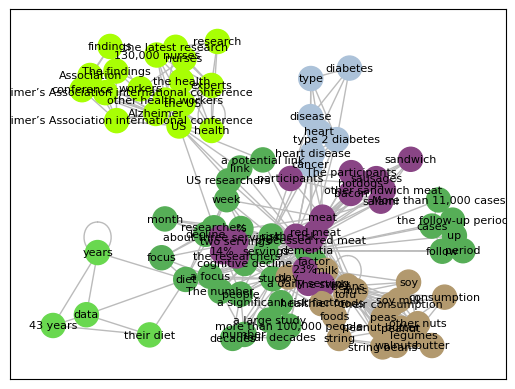

In [25]:
SPRING_DISTANCE: float = 2.5

nx.draw_networkx(
    graph,
    pos=nx.spring_layout(
        graph,
        k=SPRING_DISTANCE / len(communities),
    ),
    labels=labels,
    node_color=colors,
    edge_color="#bbb",
    with_labels=True,
    font_size=8,
)

## Tear down


How much did the global data structures grow?


In [26]:
ic(len(known_lemma))
ic(len(span_decoder))
ic(len(graph.nodes()))

ic| len(known_lemma): 99
ic| len(span_decoder): 96
ic| len(graph.nodes()): 99


99

Stop the profiler and report the performance measures.


In [27]:
profiler.stop()
profiler.print()


  _     ._   __/__   _ _  _  _ _/_   Recorded: 23:02:09  Samples:  36609
 /_//_/// /_\ / //_// / //_'/ //     Duration: 1399.884  CPU time: 49.544
/   _/                      v5.0.1

Profile at /var/folders/xx/bd1n9dh91yl75wqwj1g3nm8m0000gn/T/ipykernel_80855/382364451.py:2

1399.880 _UnixSelectorEventLoop._run_once  asyncio/base_events.py:1915
├─ 1272.256 KqueueSelector.select  selectors.py:558
│  └─ 1272.253 kqueue.control  <built-in>
└─ 127.623 Handle._run  asyncio/events.py:86
      [11 frames hidden]  ipykernel, IPython
         127.017 ZMQInteractiveShell.run_ast_nodes  IPython/core/interactiveshell.py:3420
         └─ 115.851 <module>  ../ipykernel_80855/247616181.py:1
            └─ 115.173 English.add_pipe  spacy/language.py:767
                  [61 frames hidden]  spacy, confection, glirel, huggingfac...




## Quality checks


Are there any prounoun lemmas that we need to add to the `STOP_WORDS` list? Until we have a good _coreference_ stage in this workflow, the pronouns are too generic and tend to distort the graph results. NB: compound references are "contained" and not a problem.


In [28]:
for x in known_lemma:
    if "PRON" in x:
        print(x)

PRON.their NOUN.diet
PRON.their NOUN.consumption


Which nodes should we promote to the next level?


In [30]:
kept_nodes: typing.Set[int] = set()

for node_id, node_attr in graph.nodes(data=True):
    if node_attr["kind"] == "Entity":
        print(
            node_id,
            node_attr["key"],
            node_attr["rank"],
            node_attr["label"],
            node_attr["text"],
            node_attr["chunk"],
        )
        kept_nodes.add(node_id)

1 NOUN.risk 0.022273445844157014 NP risk 1
3 NOUN.dementia 0.03784166316954037 Condition dementia 1
4 NOUN.study 0.02229484466199892 Research study 1
5 NOUN.people 0.012274218272678633 NP people 1
7 NOUN.cancer 0.009973370015756003 Condition cancer 1
12 PROPN.us 0.02492329716584656 Country US 1
13 NOUN.researcher 0.01706818283821244 People Group researchers 1
16 NOUN.nut 0.023218751670599603 Food nuts 1
17 NOUN.bean 0.023905882300761638 Food beans 1
18 NOUN.tofu 0.021581423001160435 Food tofu 1
24 NOUN.diet 0.014910001675728073 NP diet 1
28 NOUN.expert 0.012082506905866753 NP experts 1
33 NOUN.datum 0.007574845334096963 NP data 1
35 NOUN.bacon 0.009197546265640623 Food bacon 1
36 NOUN.hotdog 0.010179737953615308 Food hotdogs 1
37 NOUN.sausage 0.009134814405229206 Food sausages 1
38 NOUN.salami 0.009134814405229206 Food salami 1
41 NOUN.legume 0.011331612399829081 NP legumes 1
42 NOUN.peanut 0.01290178057186229 Food peanut 1
44 NOUN.walnut 0.01122625135220749 Food walnuts 1
46 NOUN.pea 

Which edges should we promote to the next level?


In [31]:
skip_rel: typing.Set[str] = set(["FOLLOWS_LEXICALLY", "COMPOUND_ELEMENT_OF"])

for src_id, dst_id, edge_attr in graph.edges(data=True):
    if src_id in kept_nodes and dst_id in kept_nodes:
        rel: str = edge_attr["rel"]

        if rel not in skip_rel:
            print(src_id, dst_id, rel, edge_attr["prob"])

1 5 CO_OCCURS_WITH 1.0
1 79 CO_OCCURS_WITH 1.0
1 80 CO_OCCURS_WITH 1.0
1 62 CO_OCCURS_WITH 1.0
3 67 CO_OCCURS_WITH 1.0
3 68 CO_OCCURS_WITH 1.0
3 69 CO_OCCURS_WITH 1.0
3 70 CO_OCCURS_WITH 1.0
3 58 CO_OCCURS_WITH 1.0
3 72 CO_OCCURS_WITH 1.0
3 73 CO_OCCURS_WITH 1.0
3 71 CO_OCCURS_WITH 1.0
3 74 CO_OCCURS_WITH 1.0
3 75 CO_OCCURS_WITH 1.0
3 16 CO_OCCURS_WITH 1.0
3 79 CO_OCCURS_WITH 1.0
3 80 CO_OCCURS_WITH 1.0
3 62 CO_OCCURS_WITH 1.0
3 91 CO_OCCURS_WITH 1.0
3 92 CO_OCCURS_WITH 1.0
3 97 CO_OCCURS_WITH 1.0
3 98 CO_OCCURS_WITH 1.0
3 63 CO_OCCURS_WITH 1.0
4 13 CO_OCCURS_WITH 1.0
4 79 CO_OCCURS_WITH 1.0
4 80 CO_OCCURS_WITH 1.0
4 62 CO_OCCURS_WITH 1.0
4 97 CO_OCCURS_WITH 1.0
4 98 CO_OCCURS_WITH 1.0
4 71 CO_OCCURS_WITH 1.0
4 17 CO_OCCURS_WITH 1.0
4 18 CO_OCCURS_WITH 1.0
4 58 CO_OCCURS_WITH 1.0
4 63 CO_OCCURS_WITH 1.0
5 13 CO_OCCURS_WITH 1.0
5 79 CO_OCCURS_WITH 1.0
5 80 CO_OCCURS_WITH 1.0
5 62 CO_OCCURS_WITH 1.0
7 71 CO_OCCURS_WITH 1.0
7 58 CO_OCCURS_WITH 1.0
7 59 CO_OCCURS_WITH 1.0
7 60 CO_OCCURS_WI